## Start of the LNG Project

In [305]:
# Importing Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Webdrivers and Such
from bs4 import BeautifulSoup as bsoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from IPython.display import display, HTML

# Importing Stats 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from numpy import log
import statsmodels.api as sm
from statistics import mean


In [306]:
# Going to the start of the webpage
# url = "https://www.eia.gov/dnav/ng/ng_move_expc_s1_m.htm"

# # Setting options to not open the browser / make headless
# options = webdriver.ChromeOptions()
# # options.add_argument("headless")

# # Changing the download options
# prefs = {"profile.default_content_settings.popups": 0,
#         "download.default_directory": r"C:\Users\user_dir\Desktop\\", # IMPORTANT - ENDING SLASH V IMPORTANT
#         "directory_upgrade": True}
# options.add_experimental_option('prefs',prefs)


# # Webdriver is in the hw file. But Driver Path is the location in which the chromedriver is located
# DRIVER_PATH = 'chromedriver'
# driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)

# # Placing the Website in the webdriver
# driver.get(url)

# # Going through the webpage and finding the new excel file
# file_link = driver.find_element(By.CLASS_NAME, "crumb").send_keys(Keys.ENTER)
# file_link

In [307]:
# Importing the LNG Raw File
xl = pd.ExcelFile('NG_MOVE_EXPC_S1_M.xls')

# Parsing through the excel sheets
xl_sheets = [xl.parse(sheet) for sheet in xl.sheet_names]

# displaying length of the sheet
display(xl.sheet_names)


['Contents', 'Data 1', 'Data 2']

In [308]:
# Displaying the Graph inside sheet 1
Data_Description = xl_sheets[0].iloc[5:7,1:6].rename(columns=xl_sheets[0].iloc[4,1:6])
display(Data_Description)

,Worksheet Name,Description,# Of Series,Frequency,Latest Data for
5,Data 1,Export Volumes,69,Monthly,2/2022
6,Data 2,Export Prices,69,Monthly,2/2022


,Back to Contents,Data 1: Export Volumes,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69
0,Sourcekey,N9130US2,N9132US2,N9132CN2,N9132MX2,N9133US2,NGM_EPG0_EVT_NUS-Z00_MMCF,NGM_EPG0_EVE_NUS-Z00_MMCF,NGM_EPG0_EVE_NUS-NAC_MMCF,NGM_EPG0_EVE_NUS-NAT_MMCF,...,NGM_EPG0_ERE_NUS-NIN_MMCF,NGM_EPG0_ERE_NUS-NJA_MMCF,NGM_EPG0_ERE_NUS-NMX_MMCF,NGM_EPG0_ERE_NUS-NPO_MMCF,NGM_EPG0_ERE_NUS-NKS_MMCF,NGM_EPG0_ERE_NUS-NSP_MMCF,NGM_EPG0_ERE_NUS-NTU_MMCF,NGM_EPG0_ERE_NUS-NUK_MMCF,NGM_EPG0_ENC_NUS-Z00_MMCF,NGM_EPG0_ENC_NUS-NCA_MMCF
1,Date,U.S. Natural Gas Exports (MMcf),U.S. Natural Gas Pipeline Exports (MMcf),U.S. Natural Gas Pipeline Exports to Canada (M...,U.S. Natural Gas Pipeline Exports to Mexico (M...,Liquefied U.S. Natural Gas Exports (MMcf),Liquefied U.S. Natural Gas Exports by Vessel a...,Liquefied U.S. Natural Gas Exports by Vessel (...,U.S. Liquefied Natural Gas Exports by Vessel t...,Liquefied U.S. Natural Gas Exports by Vessel t...,...,Liquefied U.S. Natural Gas Re-Exports to India...,Liquefied U.S. Natural Gas Re-Exports to Japan...,Liquefied U.S. Natural Gas Re-Exports to Mexic...,Liquefied U.S. Natural Gas Re-Exports to Portu...,Liquefied U.S. Natural Gas Re-Exports to South...,U.S. Liquefied Natural Gas Re-Exports to Spai...,Liquefied U.S. Natural Gas Re-Exports to Turke...,Liquefied U.S. Natural Gas Re-Exports to Unite...,Compressed U.S. Natural Gas Exports (Million C...,U.S. Compressed Natural Gas Exports to Canada ...
2,1973-01-15 00:00:00,5808,NaN,60,1373,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1973-02-15 00:00:00,6079,NaN,384,1275,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1973-03-15 00:00:00,4021,NaN,1167,1391,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


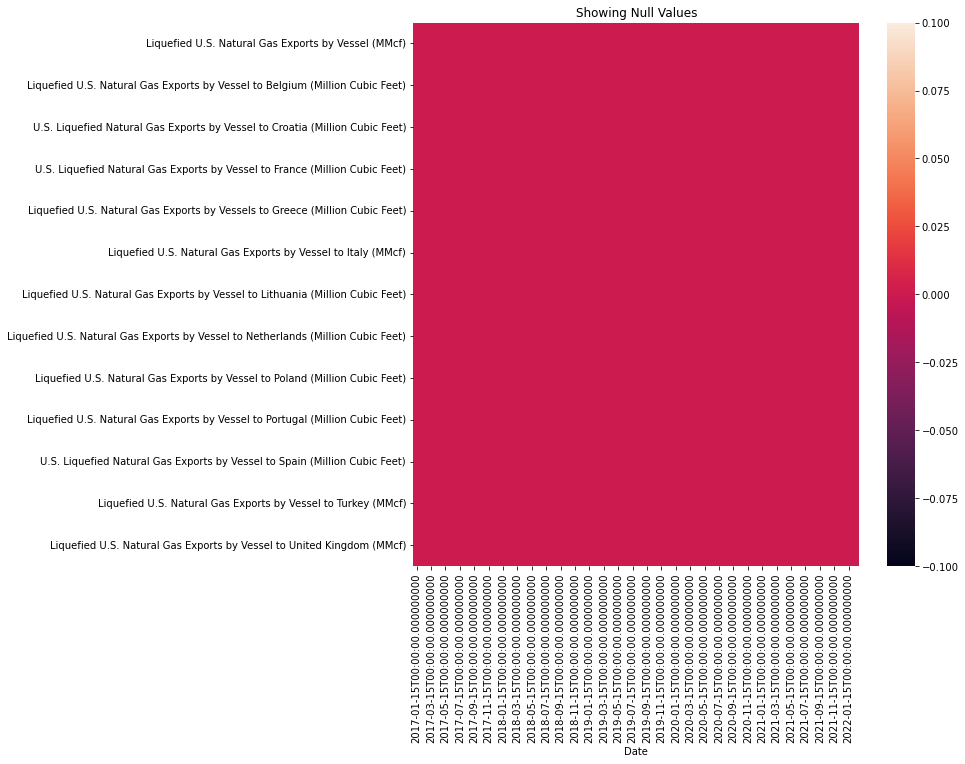

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2017-01-15 to 2022-02-15
Data columns (total 13 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Liquefied U.S. Natural Gas Exports by Vessel (MMcf)                               62 non-null     float64
 1   Liquefied U.S. Natural Gas Exports by Vessel to Belgium (Million Cubic Feet)      62 non-null     float64
 2   U.S. Liquefied Natural Gas Exports by Vessel to Croatia (Million Cubic Feet)      62 non-null     float64
 3   U.S. Liquefied Natural Gas Exports by Vessel to France (Million Cubic Feet)       62 non-null     float64
 4   Liquefied U.S. Natural Gas Exports by Vessels to Greece (Million Cubic Feet)      62 non-null     float64
 5   Liquefied U.S. Natural Gas Exports by Vessel to Italy (MMcf)                      62 non-null  

None

In [309]:
# Now to import the two other sheets
def LNG_Scrubber(df, others, na_graph):
    """This function takes in the LNG Files and scrubs Them"""
    # Displaying the Raw Data Head
    if na_graph:
        display(df.head(5))

    # Grabbing the Column Headers and dropping Columns we don't care about. Setting the index to date
    new_cols = df.iloc[1]
    df = df.iloc[2:].copy()
    df.rename(columns=new_cols, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Setting the Index as Date Time
    df.set_index('Date', inplace=True)

    # List of Columns to keep
    col_list = []
    
    # Trigger to include other countries of interest
    # TODO Will want to figure out how to append this better. Maybe even add a column for indicating of interest ext
    if others:
        countries = ['Japan', 'Israel', 'China', 'India', 'Russia', 'Taiwan', 'South Korea']
    else:
        # Selecting NATO Countries
        countries = ['Albania', 'Belgium', 'Bulgaria', 'Canada', 'Croatia', 'Czech Rep', 'Denmark', 'Estonia', 'France', 'Germany', 'Greece', 'Hungary',
                    'Iceland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
                    'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Turkey', 'United Kingdom']

    # Looping through the list an keeping a list of cols that are in Nato
    # Also Scrubbing out other columns that are not needed Re-Exports, Truck... only looking for vessel exports
    for col in enumerate(df.columns[2:]):
        for word in countries:
            if (col[1].find('to') < 0 and col[1].find('Re-Exports') < 0 and col[1].find('Truck') < 0 and col[1].find('Vessel') > 0) \
                 or (col[1].find(word) > 0 and col[1].find('Re-Exports') < 0 and col[1].find('Vessel') > 0):
                df[col[1]] = df[col[1]].astype('float64')
                col_list.append(col[1])

    # Just DF for countries
    df = df.loc[:, df.columns.isin(col_list)]
    
    # Grabbing a Certain timeframe
    df = df.loc[df.index >= '2017-01-01']

    # Replacing all the NaN values with 0
    df = df.replace([np.NaN], 0)

    if na_graph:
        # Displaying a heat map of the head 100
        plt.figure(figsize=(10,10))
        sns.heatmap(df.isna().T)
        plt.title("Showing Null Values")
        plt.show()
        display(df.info())

    return df


# Grabbing the two data sheets
Export_Vol = xl_sheets[1]
Export_Price = xl_sheets[2]


Export_Vol_nato_us = LNG_Scrubber(Export_Vol, False, True)


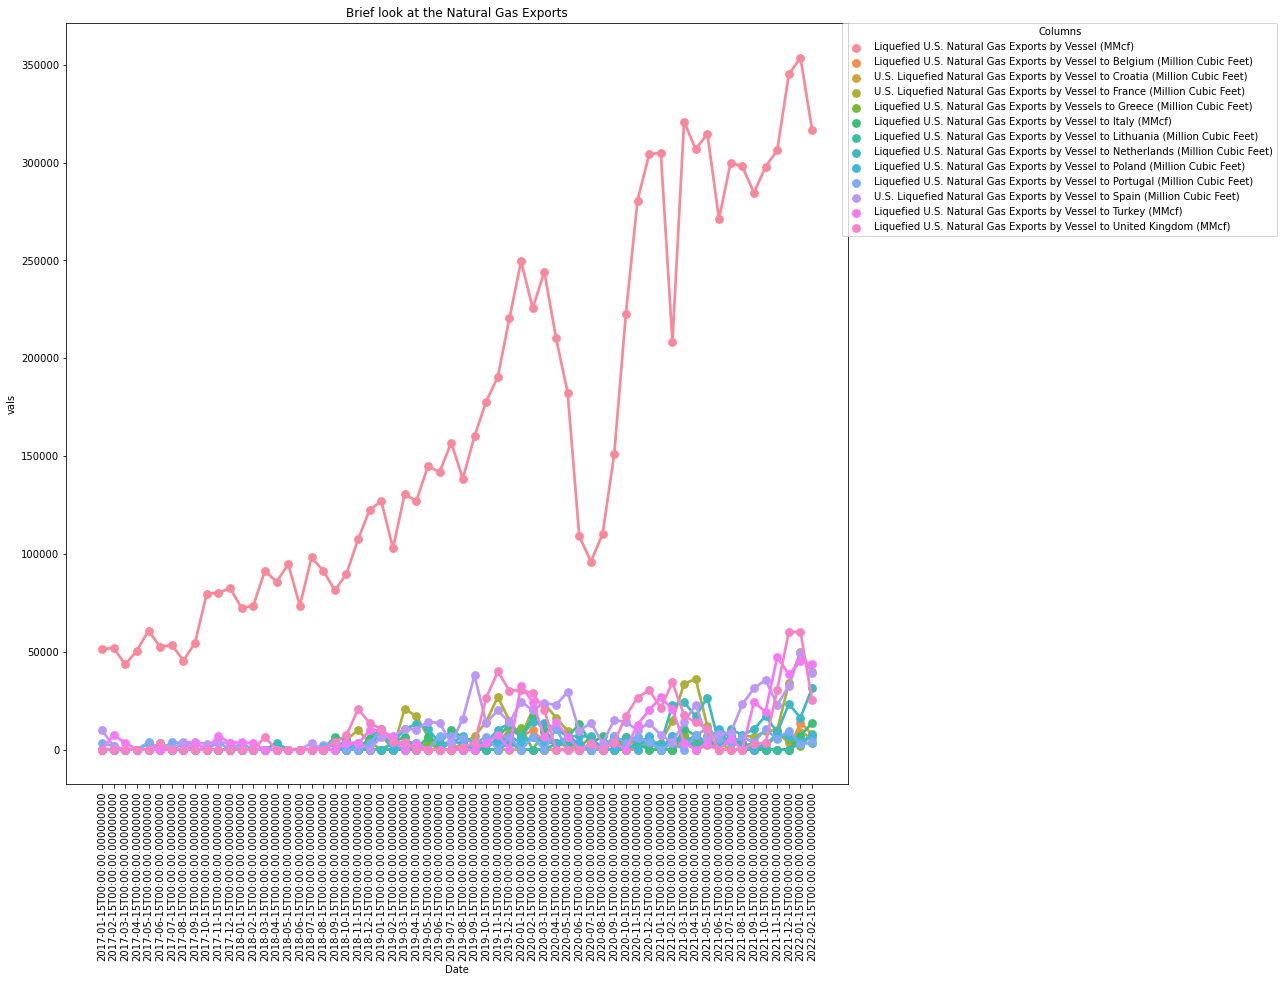

In [310]:
# Showing a plot of the data that we have no recieved
def graphit(df):
    """This Function graphs everything in a lineplot that it is passed"""
    df_graph = df.copy()
    df_graph.reset_index(drop=False, inplace=True)
    # df_graph["Date"] = pd.to_datetime(df_graph["Date"])
    dfm =  df_graph.melt(id_vars='Date', var_name='cols', value_name='vals')

    # Displaying the Graphs
    plt.figure(figsize=(14,14))
    sns.pointplot(x="Date", y="vals", hue='cols', data=dfm)
    plt.legend(title="Columns", bbox_to_anchor=(1.55,1), loc='upper right', borderaxespad=0)
    plt.xticks(rotation=90)
    plt.title("Brief look at the Natural Gas Exports")
    
    
    plt.plot()

graphit(Export_Vol_nato_us)

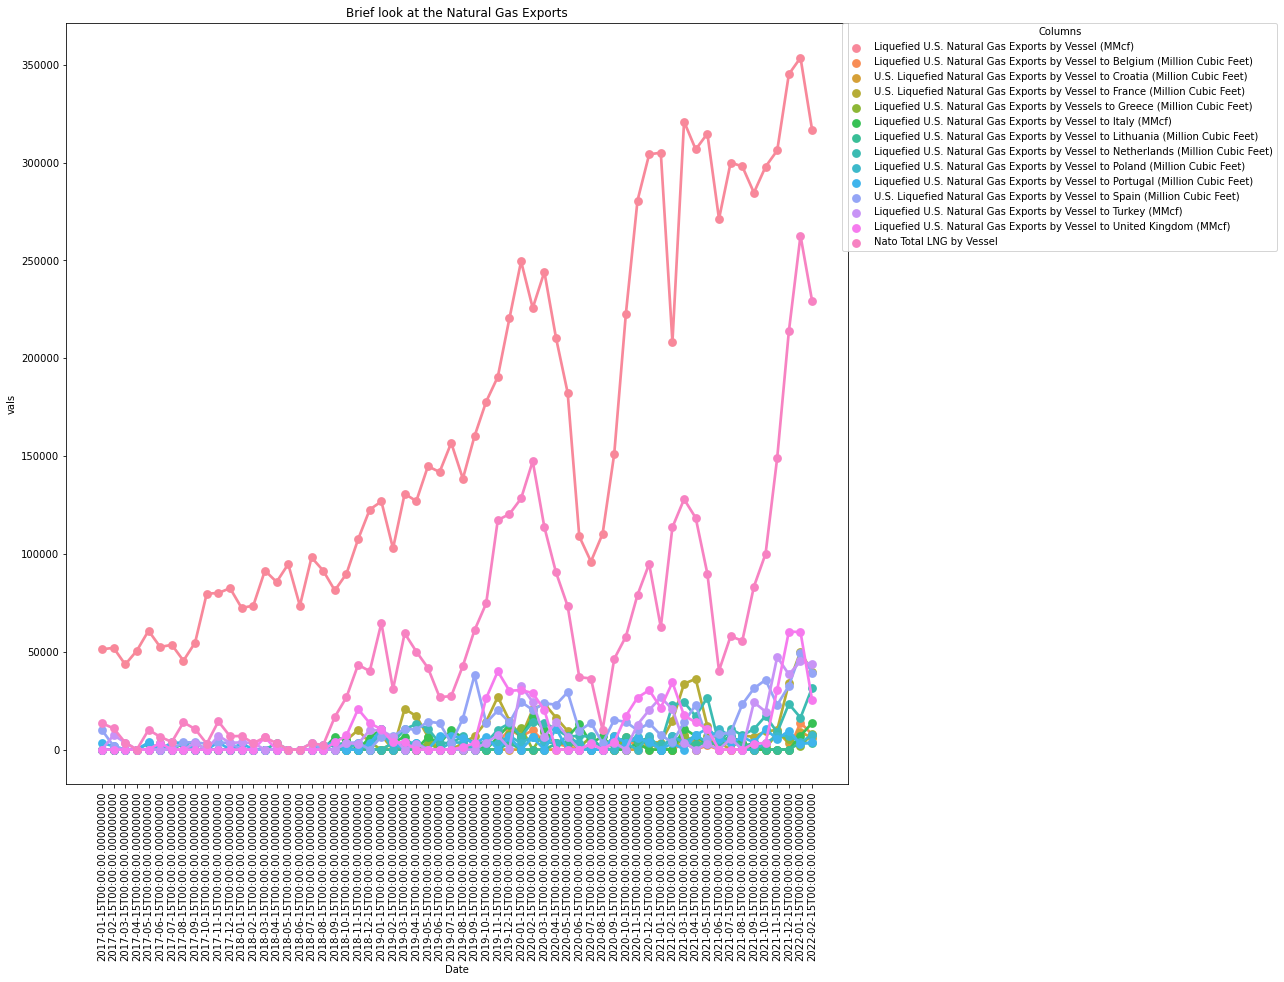

In [311]:
# Now just looking at all the Nato Exports by Vessel
cols_exclude = ['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)']

# Now to tally all of the Nato Exports
Export_Vol_nato_only = Export_Vol_nato_us.drop(columns=cols_exclude)
Export_Vol_nato_us['Nato Total LNG by Vessel'] = Export_Vol_nato_only.sum(axis=1)

# Graphing the Natural Gas Exports by Vessel to Nato Countries
graphit(Export_Vol_nato_us)


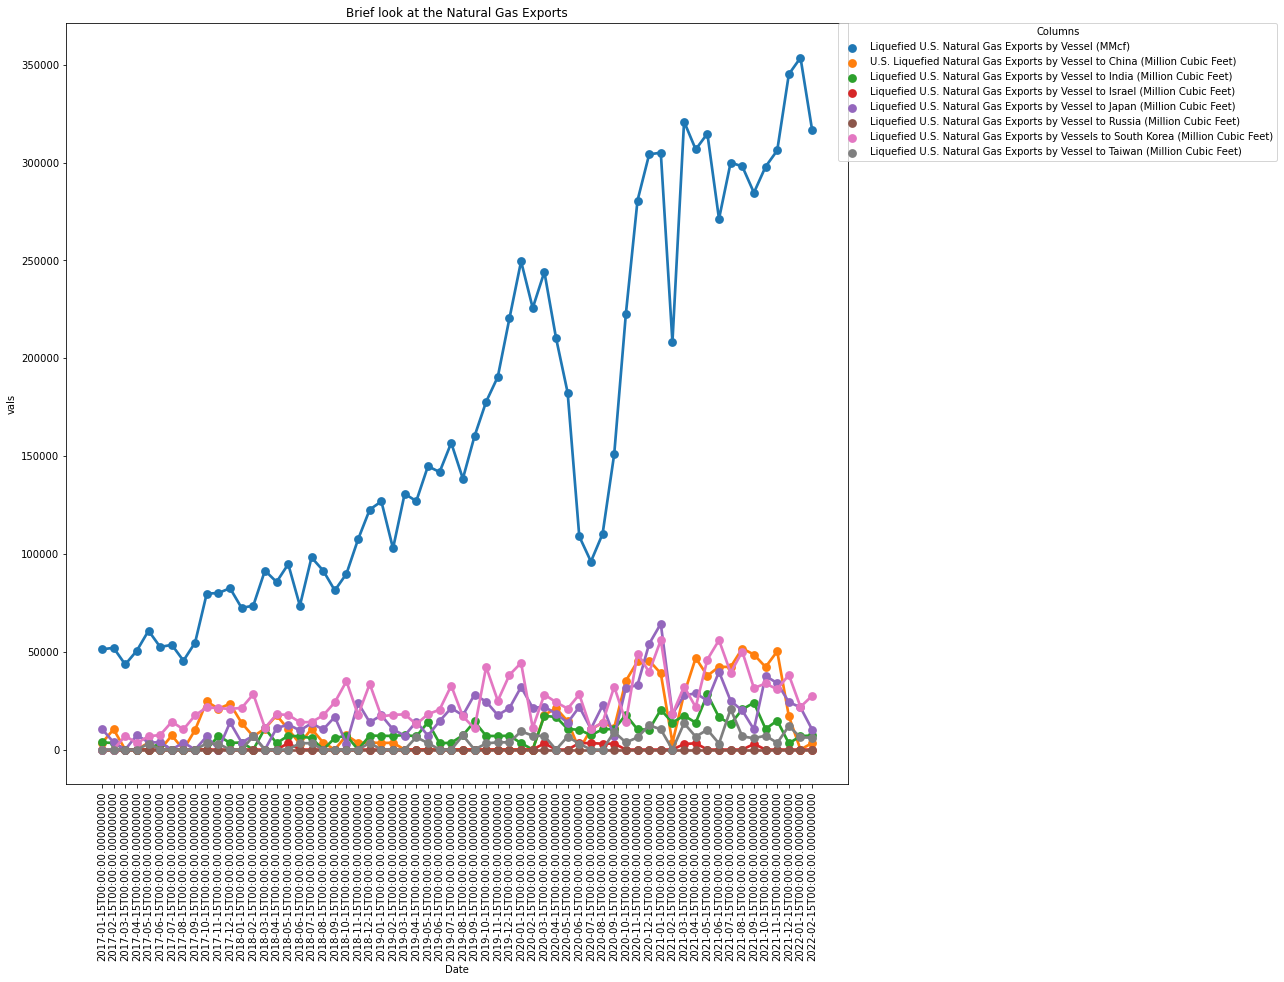

In [312]:
# Now going through and see if there are others that we want to look in
Export_Vol_others = LNG_Scrubber(Export_Vol, True, False)

graphit(Export_Vol_others)

When looking at the graph above you can see that China was rising then quickly goes close to zero. Russua was sitting close to cero the whole time.  Most notably
Tiawain exports are starting to increase.

## Starting the ARIMA MODELS
From here we will look into the Arima model and determine what we can forcast.


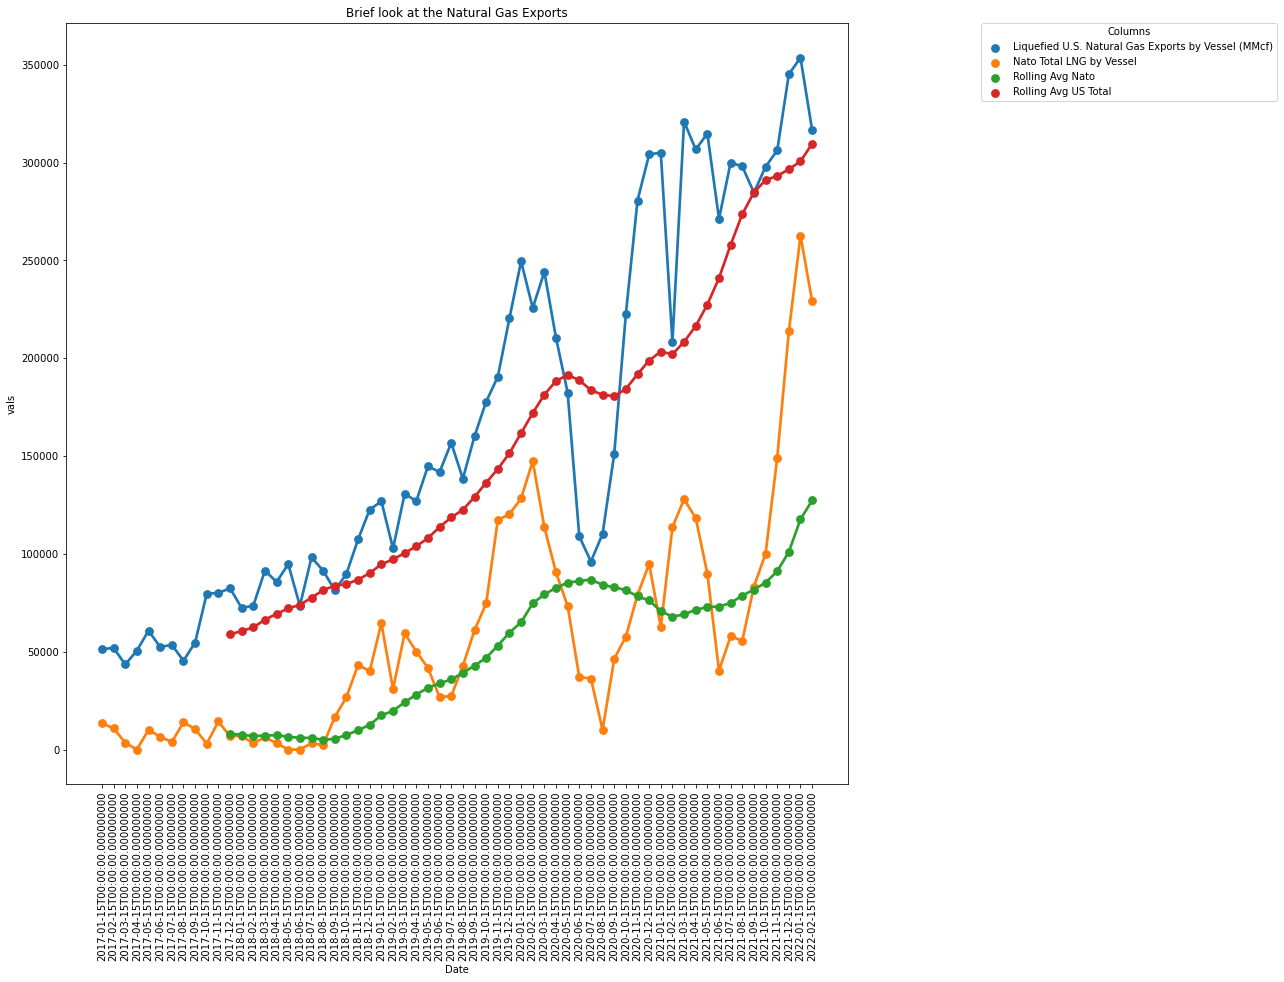

In [313]:
# Creating the Rolling averages
# Note that the 12 month rolling averages is adding in some issues
Arima_DF = Export_Vol_nato_us.loc[:,['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)','Nato Total LNG by Vessel']]
Arima_DF['Rolling Avg Nato'] = Arima_DF.loc[:,'Nato Total LNG by Vessel'].rolling(window=12).mean()
Arima_DF['Rolling Avg US Total'] = Arima_DF.loc[:,'Liquefied U.S. Natural Gas Exports by Vessel (MMcf)'].rolling(window=12).mean()

graphit(Arima_DF)

In [314]:

Arima_DF['Year'] = Arima_DF.index.year
Arima_DF['Month'] = Arima_DF.index.month
US_Export = pd.pivot_table(Arima_DF, index=['Month'], columns=['Year'], values=['Rolling Avg US Total'])
Nato_Export = pd.pivot_table(Arima_DF, index=['Month'], columns=['Year'], values=['Rolling Avg Nato'])



[]

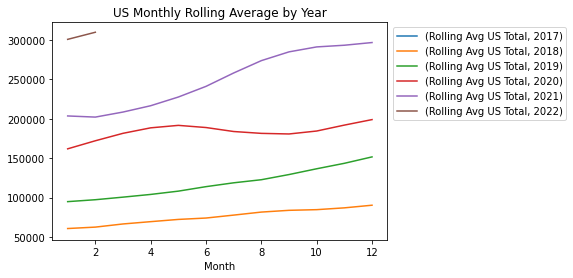

In [315]:
US_Export.plot()
plt.legend(bbox_to_anchor=(1.55, 1), loc='upper right')
plt.title('US Monthly Rolling Average by Year')
plt.plot()

[]

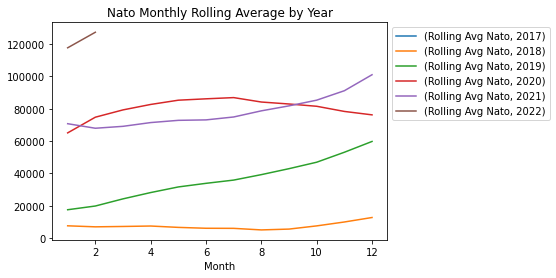

In [316]:
Nato_Export.plot()
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.title('Nato Monthly Rolling Average by Year')
plt.plot()

In [317]:
# Augmented Dickey-Fuller Test to Test Stationarity
def run_adftest(s):
  print("Dickey-Fuller Test")
  adftest = adfuller(s, autolag='AIC')
  print(f"Test Statistic: {adftest[0]}")
  print(f"p-value: {adftest[1]}")
  print("Critical Values:")
  for k, v in adftest[4].items():
      print("\t{}: {} - The data is{} stationary with {}% confidence".format(k, v, " not" if v<adftest[0] else "", 100-int(k[:-1])))

display("Running Dickey-Fuller on Nato Exports")
run_adftest(Arima_DF['Nato Total LNG by Vessel'])

display("Running Dickey-Fuller on US Exports")
run_adftest(Arima_DF['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)'])

'Running Dickey-Fuller on Nato Exports'

Dickey-Fuller Test
Test Statistic: 0.24190905334212084
p-value: 0.974516583684793
Critical Values:
	1%: -3.55770911573439 - The data is not stationary with 99% confidence
	5%: -2.9167703434435808 - The data is not stationary with 95% confidence
	10%: -2.59622219478738 - The data is not stationary with 90% confidence


'Running Dickey-Fuller on US Exports'

Dickey-Fuller Test
Test Statistic: -1.0032566803096654
p-value: 0.7520746493490622
Critical Values:
	1%: -3.542412746661615 - The data is not stationary with 99% confidence
	5%: -2.910236235808284 - The data is not stationary with 95% confidence
	10%: -2.5927445767266866 - The data is not stationary with 90% confidence


[]

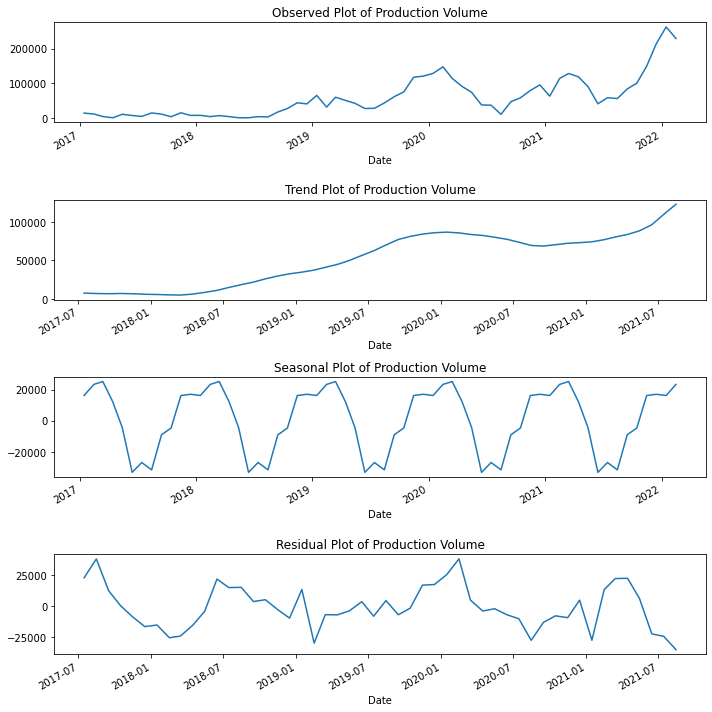

In [318]:
# The data above is not stationary. We will look at the seasonal decomposition
nato_sd = seasonal_decompose(Arima_DF[['Nato Total LNG by Vessel']], model='additive', period=12)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(10,10))
Arima_DF['Nato Total LNG by Vessel'].plot(ax=ax0)
nato_sd.trend.plot(ax=ax1)
nato_sd.seasonal.plot(ax=ax2)
nato_sd.resid.plot(ax=ax3)


ax0.set_title("Observed Plot of Production Volume")
ax1.set_title("Trend Plot of Production Volume")
ax2.set_title("Seasonal Plot of Production Volume")
ax3.set_title("Residual Plot of Production Volume")
plt.tight_layout()
plt.plot()


[]

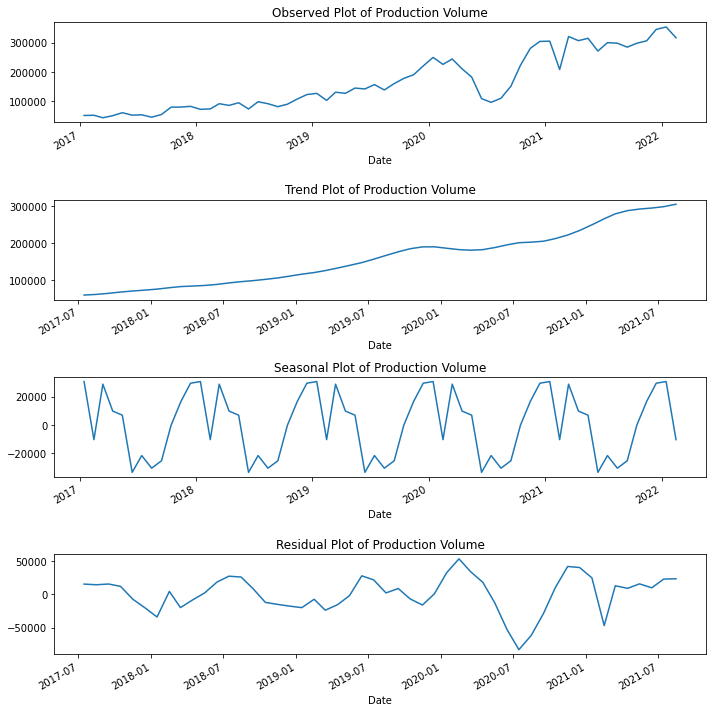

In [319]:
# The data above is not stationary. We will look at the seasonal decomposition
# seasonal_decompose(Arima_DF.loc[:, 'Nato Total LNG by Vessel'])
us_sd = seasonal_decompose(Arima_DF[['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)']], model='additive', period=12)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(10,10))
Arima_DF['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)'].plot(ax=ax0)
us_sd.trend.plot(ax=ax1)
us_sd.seasonal.plot(ax=ax2)
us_sd.resid.plot(ax=ax3)


ax0.set_title("Observed Plot of Production Volume")
ax1.set_title("Trend Plot of Production Volume")
ax2.set_title("Seasonal Plot of Production Volume")
ax3.set_title("Residual Plot of Production Volume")
plt.tight_layout()
plt.plot()


Based on the plots above we can see that
* there is a linear trend
* there is a seasonality component
* the residuals are not like white noise since the variance changes

From the dickey fuller test we can also see that the data is not stationary. Because of this we need to use some differencing

<AxesSubplot:xlabel='Date'>

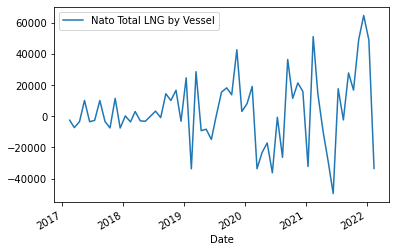

In [320]:
diffed_series = Arima_DF[['Nato Total LNG by Vessel']].diff(1) # default periods value of 1
diffed_series.plot()

[]

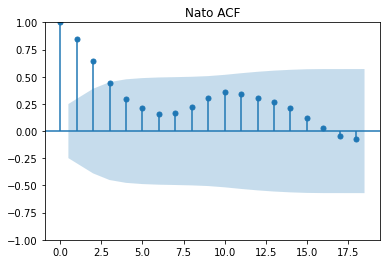

In [321]:
plot_acf(Arima_DF[['Nato Total LNG by Vessel']])
plt.title("Nato ACF")
plt.plot()

[]

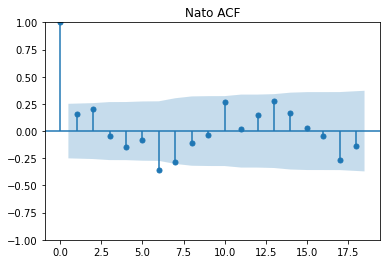

In [322]:
plot_acf(Arima_DF[['Nato Total LNG by Vessel']].diff(1).dropna())
plt.title("Nato ACF")
plt.plot()

c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

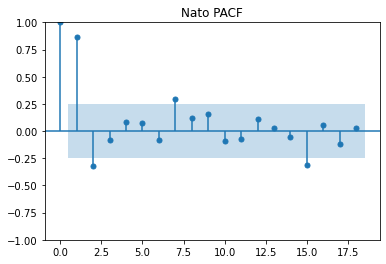

In [323]:
plot_pacf(Arima_DF[['Nato Total LNG by Vessel']])
plt.title('Nato PACF')
plt.plot()

c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

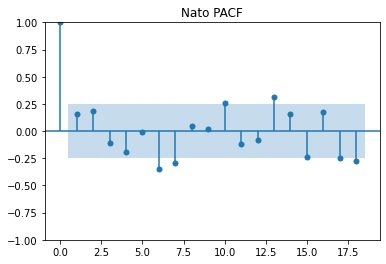

In [324]:
plot_pacf(Arima_DF[['Nato Total LNG by Vessel']].diff(1).dropna())
plt.title('Nato PACF')
plt.plot()

In [325]:
# The differenced data is now stationary. We can use this for ARIMA
run_adftest(Arima_DF[['Nato Total LNG by Vessel']].diff(1).dropna())

Dickey-Fuller Test
Test Statistic: -6.096446373491745
p-value: 1.007395826213191e-07
Critical Values:
	1%: -3.55770911573439 - The data is stationary with 99% confidence
	5%: -2.9167703434435808 - The data is stationary with 95% confidence
	10%: -2.59622219478738 - The data is stationary with 90% confidence


In [326]:
Arima_DF.info()
Arima_DF.drop(columns=['Month', 'Year'], inplace=True)
Arima_DF.dropna(axis=0, how='any', inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2017-01-15 to 2022-02-15
Data columns (total 6 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Liquefied U.S. Natural Gas Exports by Vessel (MMcf)  62 non-null     float64
 1   Nato Total LNG by Vessel                             62 non-null     float64
 2   Rolling Avg Nato                                     51 non-null     float64
 3   Rolling Avg US Total                                 51 non-null     float64
 4   Year                                                 62 non-null     int64  
 5   Month                                                62 non-null     int64  
dtypes: float64(4), int64(2)
memory usage: 5.4 KB


'Model Arima(1,1,1)'

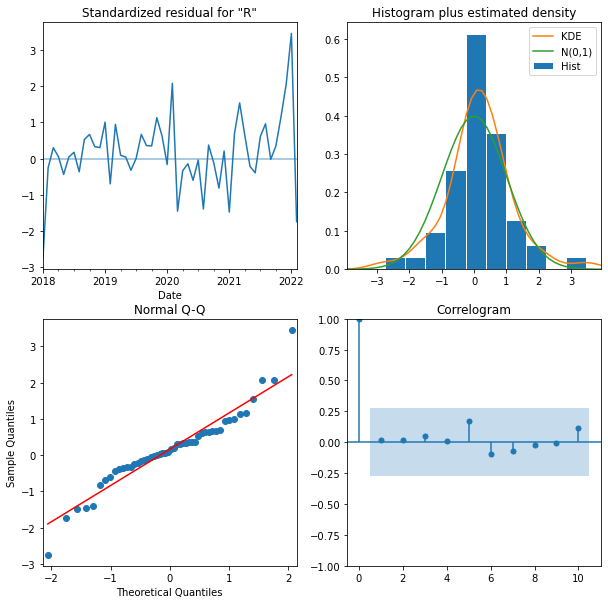

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Rolling Avg Nato   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -461.604
Date:                Thu, 02 Jun 2022   AIC                            929.207
Time:                        19:56:08   BIC                            934.944
Sample:                    12-31-2017   HQIC                           931.392
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8687      0.109      7.948      0.000       0.654       1.083
ma.L1         -0.0721      0.241     -0.300      0.764      -0.544       0.400
sigma2      5.947e+06   8.87e+05      6.705      0.000    4.21e+06    7.69e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                10.19
Prob(Q):                              0.89   Prob(JB):                         0.01
Heteroskedasticity (H):               2.49   Skew:                             0.20
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Rolling Avg US Total   No. Observations:                   51
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -490.625
Date:                  Thu, 02 Jun 2022   AIC                            987.249
Time:                          19:56:08   BIC                            992.985
Sample:                      12-31-2017   HQIC                           989.434
                           - 02-28-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   2319.199      0.000       0.999       1.001
ma.L1         -0.9997      0.122     -8.215      0.000      -1.238      -0.761
sigma2      1.911e+07   2.87e-09   6.67e+15      0.000    1.91e+07    1.91e+07
===================================================================================
Ljung-Box (L1) (Q):                  32.47   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.00   Prob(JB):                         0.44
Heteroskedasticity (H):              12.63   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+32. Standard errors may be unstable.
"""

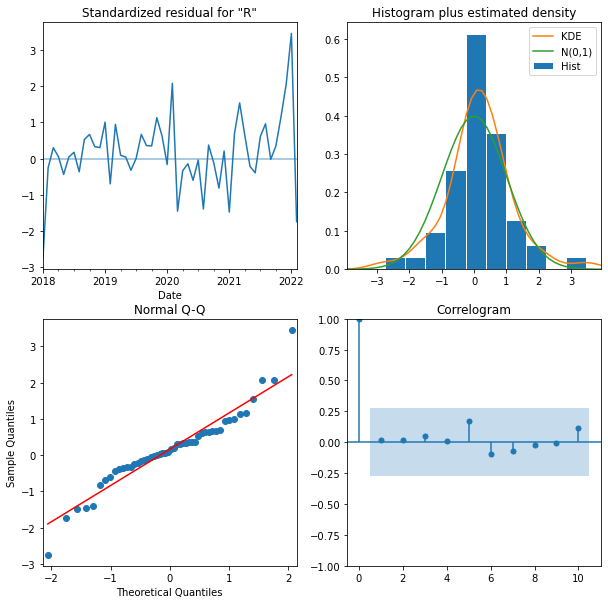

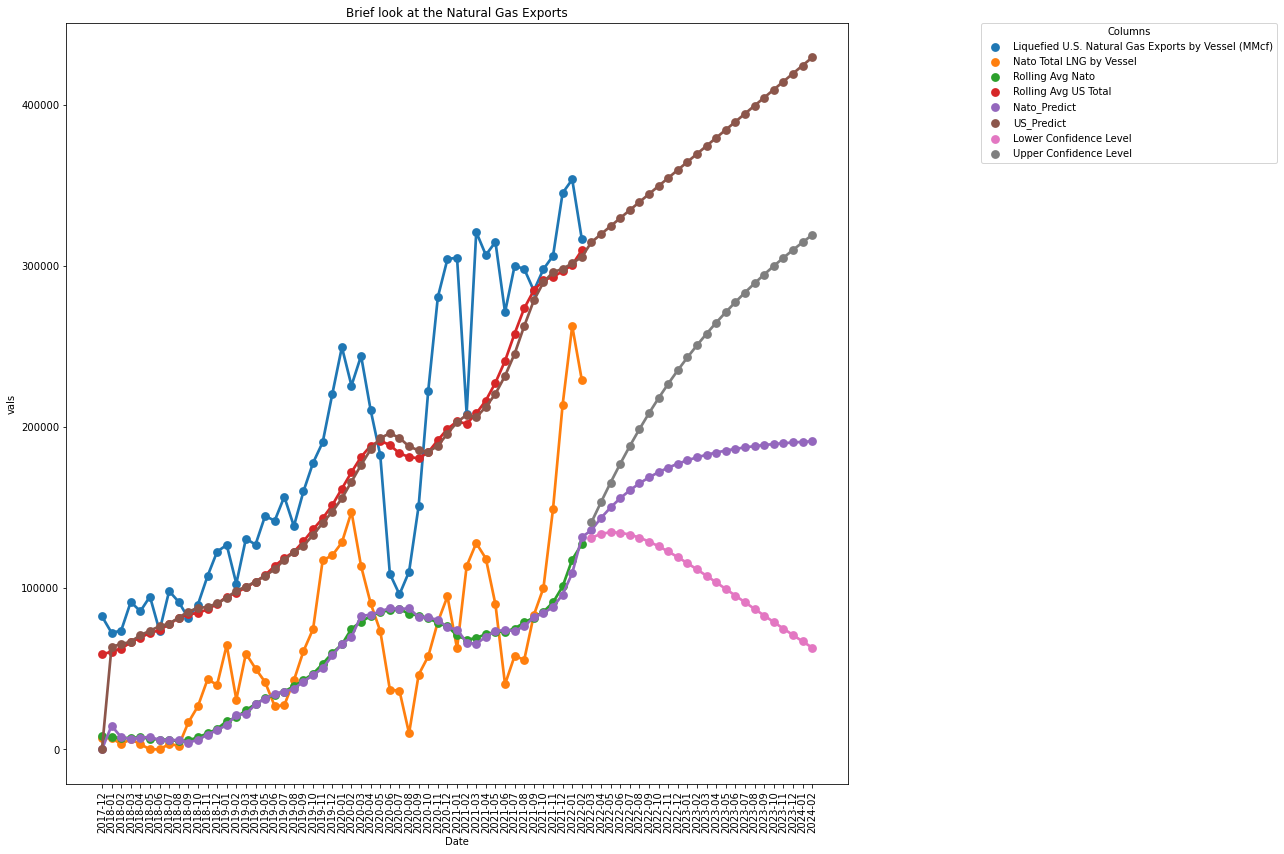

In [360]:
def run_arimma(df, p, d, q, dino):
    """This Function is aimed at running the arima modes."""
    display("Model Arima({},{},{})".format(p,d,q))
    # Setting the Frequency
    df.index = pd.period_range(min(df.index), max(df.index), freq='M')
    df.index.names = ['Date']

    # model_nato = ARIMA(Arima_DF['Nato Total LNG by Vessel'], order=(p,d,q)).fit()
    # model_us= ARIMA(Arima_DF['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)'], order=(p,d,q)).fit()

    # Fitting an Rima model on the Rolling Averages
    model_nato = ARIMA(df['Rolling Avg Nato'], order=(p,d,q)).fit()
    model_us= ARIMA(df['Rolling Avg US Total'], order=(p,d,q)).fit()

    model_nato.plot_diagnostics(figsize=(10,10))
    plt.show()

    
    display(model_nato.summary())
    display(model_us.summary())

    if dino:
        model_nato.plot_diagnostics(figsize=(10,10))
        plt.show()

    # Forcasting
    df['Nato_Predict'] = model_nato.predict()
    df['US_Predict'] = model_us.predict()

    # Forcasting
    df['Nato_Predict'] = model_nato.predict()
    df['US_Predict'] = model_us.predict()

    # Forecasting model
    md1 = pd.DataFrame(model_nato.forecast(steps=24))
    md1.index.names= ['Date']
    md1.rename(columns={'predicted_mean':'Nato_Predict'}, inplace=True)

    md2 = pd.DataFrame(model_us.forecast(steps=24))
    md2.index.names = ['Date']
    md2.rename(columns={"predicted_mean":'US_Predict'}, inplace=True)

    # Merging two predictions together
    md3 = md1.merge(md2, on='Date', how='left').copy()

    # Merging the predictions onto the original Datafram
    predict_it = pd.concat([df, md3]).copy()

    # Grabbing the Nato confidence interval
    nato_forecast = model_nato.get_forecast(50)
    conf_int = nato_forecast.conf_int(alpha=0.05)
    conf_int.index.names = ['Date']

    predict_it = predict_it.merge(conf_int, on='Date', how='left').copy()
    predict_it.rename(columns={'upper Rolling Avg Nato':'Upper Confidence Level', 'lower Rolling Avg Nato': 'Lower Confidence Level'}, inplace=True)

    graphit(predict_it)


Model_1 = run_arimma(Arima_DF,1,1,1, True)


'Model Arima(1,1,6)'

c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


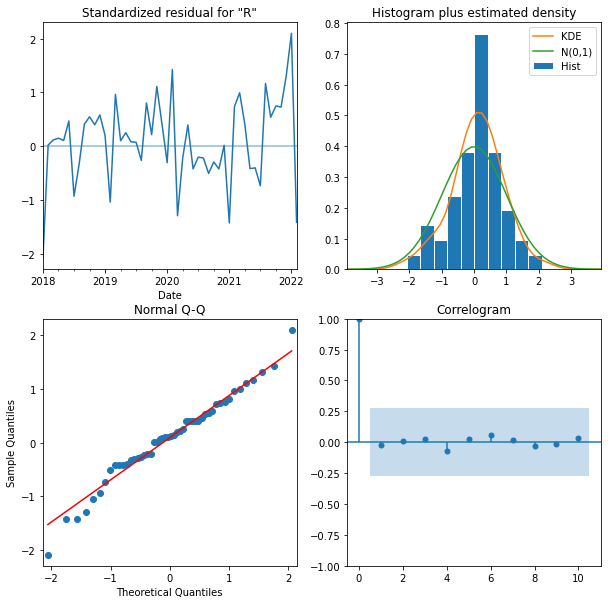

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Rolling Avg Nato   No. Observations:                   51
Model:                 ARIMA(1, 1, 6)   Log Likelihood                -458.276
Date:                Thu, 02 Jun 2022   AIC                            932.553
Time:                        19:58:27   BIC                            947.849
Sample:                    12-31-2017   HQIC                           938.377
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9948      0.137      7.248      0.000       0.726       1.264
ma.L1         -0.0819      0.366     -0.224      0.823      -0.799       0.635
ma.L2         -0.1395      0.393     -0.355      0.723      -0.910       0.631
ma.L3          0.0187      0.436      0.043      0.966      -0.835       0.872
ma.L4          0.0688      0.353      0.195      0.845      -0.623       0.760
ma.L5          0.0285      0.338      0.084      0.933      -0.633       0.690
ma.L6         -0.7983      0.258     -3.098      0.002      -1.303      -0.293
sigma2      7.046e+06   4.31e-08   1.63e+14      0.000    7.05e+06    7.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.87   Prob(JB):                         0.55
Heteroskedasticity (H):               1.82   Skew:                            -0.27
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+30. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Rolling Avg US Total   No. Observations:                   51
Model:                   ARIMA(1, 1, 6)   Log Likelihood                -492.021
Date:                  Thu, 02 Jun 2022   AIC                           1000.041
Time:                          19:58:27   BIC                           1015.337
Sample:                      12-31-2017   HQIC                          1005.866
                           - 02-28-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    494.094      0.000       0.996       1.004
ma.L1         -0.8456      0.105     -8.089      0.000      -1.051      -0.641
ma.L2         -0.0877      0.070     -1.255      0.210      -0.225       0.049
ma.L3         -0.0194      0.143     -0.135      0.892      -0.300       0.261
ma.L4         -0.0687      0.145     -0.474      0.636      -0.353       0.216
ma.L5         -0.0325      0.114     -0.285      0.776      -0.256       0.191
ma.L6          0.0554      0.074      0.752      0.452      -0.089       0.200
sigma2      9.334e+06   1.03e-08   9.09e+14      0.000    9.33e+06    9.33e+06
===================================================================================
Ljung-Box (L1) (Q):                  22.46   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.00   Prob(JB):                         0.50
Heteroskedasticity (H):               2.83   Skew:                            -0.21
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+30. Standard errors may be unstable.
"""

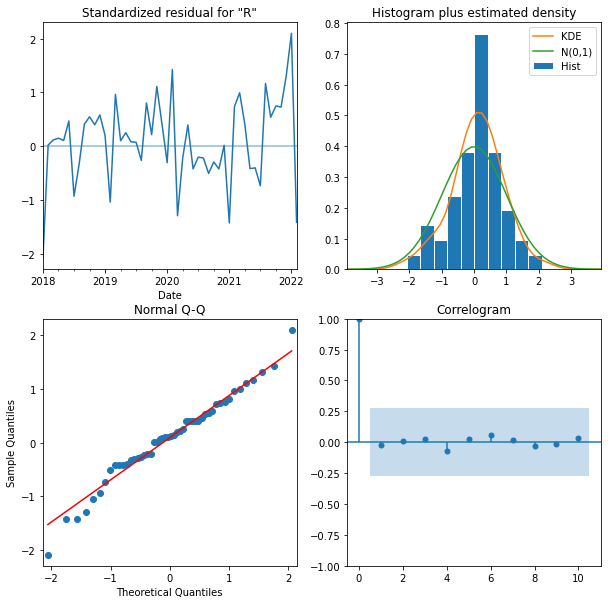

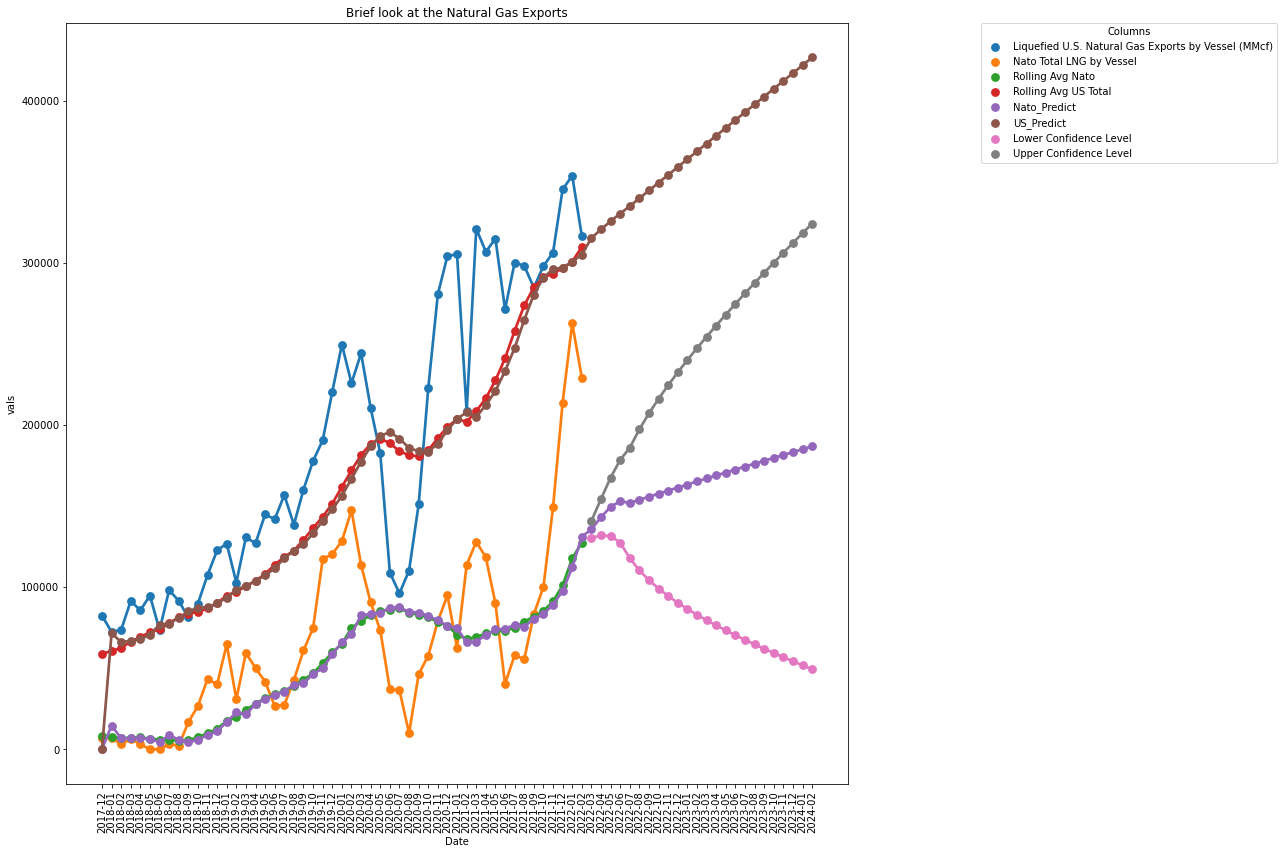

In [361]:
Model_2 = run_arimma(Arima_DF,1,1,6, True)


'Model Arima(6,1,1)'

c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


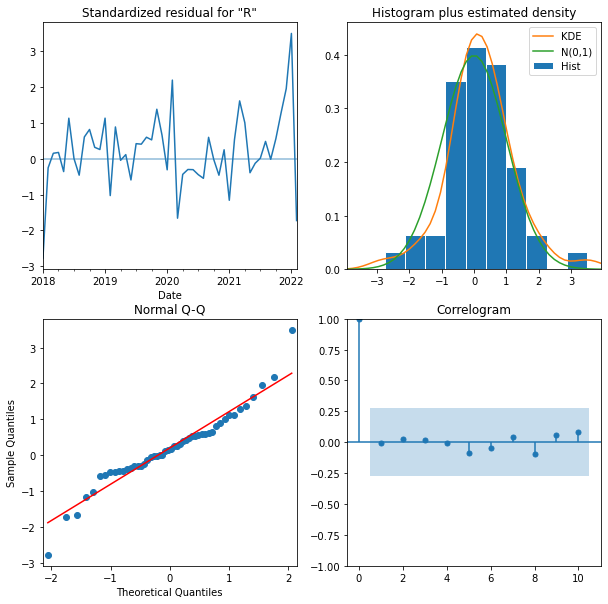

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Rolling Avg Nato   No. Observations:                   51
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -459.653
Date:                Thu, 02 Jun 2022   AIC                            935.307
Time:                        19:58:34   BIC                            950.603
Sample:                    12-31-2017   HQIC                           941.131
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6785      0.795      0.853      0.394      -0.881       2.238
ar.L2          0.1064      0.685      0.155      0.877      -1.236       1.449
ar.L3          0.1208      0.335      0.360      0.719      -0.536       0.778
ar.L4         -0.0064      0.339     -0.019      0.985      -0.671       0.658
ar.L5          0.2555      0.271      0.945      0.345      -0.275       0.786
ar.L6         -0.3504      0.201     -1.743      0.081      -0.744       0.044
ma.L1          0.1336      0.846      0.158      0.875      -1.525       1.792
sigma2      5.234e+06   3.67e-07   1.43e+13      0.000    5.23e+06    5.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.10
Prob(Q):                              0.95   Prob(JB):                         0.01
Heteroskedasticity (H):               1.95   Skew:                             0.20
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.32e+28. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Rolling Avg US Total   No. Observations:                   51
Model:                   ARIMA(6, 1, 1)   Log Likelihood                -503.726
Date:                  Thu, 02 Jun 2022   AIC                           1023.453
Time:                          19:58:34   BIC                           1038.749
Sample:                      12-31-2017   HQIC                          1029.278
                           - 02-28-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1668      0.023     50.092      0.000       1.121       1.212
ar.L2         -0.1216      0.047     -2.594      0.009      -0.213      -0.030
ar.L3         -0.0248      0.106     -0.233      0.816      -0.233       0.184
ar.L4         -0.0589      0.119     -0.496      0.620      -0.292       0.174
ar.L5         -0.0116      0.092     -0.126      0.899      -0.192       0.169
ar.L6          0.0502      0.054      0.928      0.354      -0.056       0.156
ma.L1         -0.9991      0.068    -14.776      0.000      -1.132      -0.867
sigma2      6.077e+06   1.06e-08   5.75e+14      0.000    6.08e+06    6.08e+06
===================================================================================
Ljung-Box (L1) (Q):                  21.84   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.00   Prob(JB):                         0.34
Heteroskedasticity (H):               2.72   Skew:                            -0.28
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+30. Standard errors may be unstable.
"""

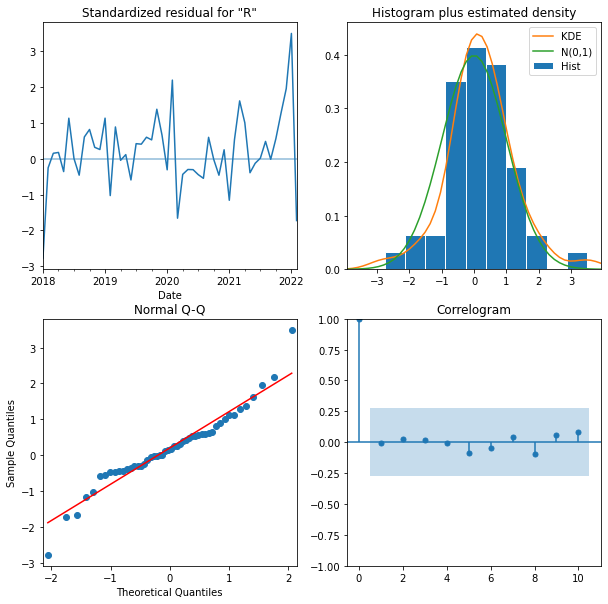

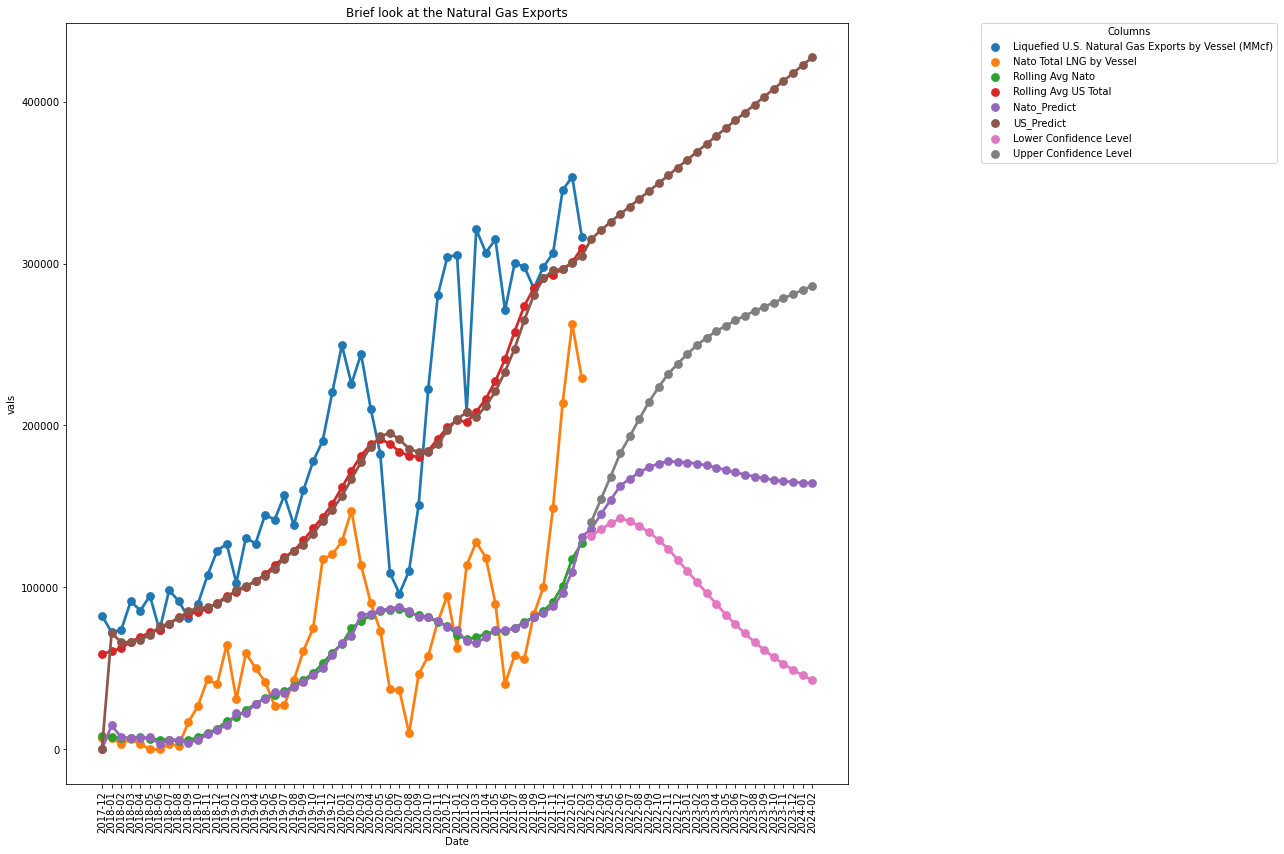

In [362]:
Model_3 = run_arimma(Arima_DF,6,1,1, True)


'Model Arima(6,1,6)'

c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

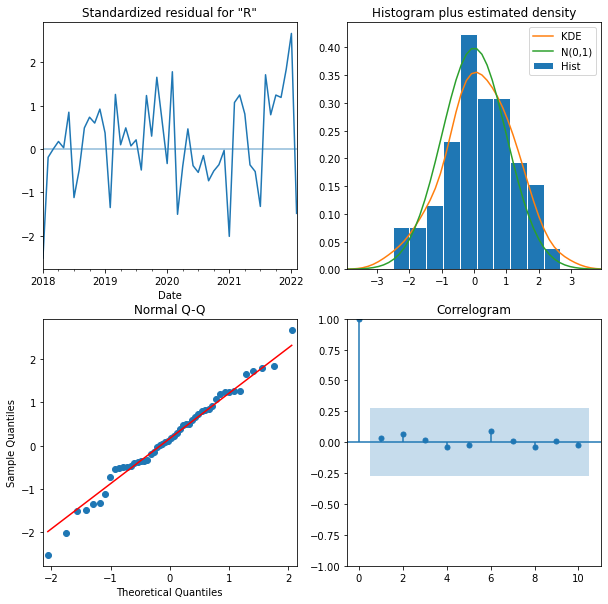

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Rolling Avg Nato   No. Observations:                   51
Model:                 ARIMA(6, 1, 6)   Log Likelihood                -454.966
Date:                Thu, 02 Jun 2022   AIC                            935.932
Time:                        19:58:46   BIC                            960.788
Sample:                    12-31-2017   HQIC                           945.397
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8835      0.321      2.753      0.006       0.255       1.512
ar.L2          0.0318      0.404      0.079      0.937      -0.759       0.823
ar.L3          0.1216      0.380      0.320      0.749      -0.622       0.866
ar.L4         -0.0813      0.468     -0.174      0.862      -0.998       0.836
ar.L5          0.1079      0.442      0.244      0.807      -0.758       0.974
ar.L6         -0.0734      0.303     -0.242      0.809      -0.667       0.521
ma.L1         -0.0038   2.44e+04  -1.55e-07      1.000   -4.77e+04    4.77e+04
ma.L2         -0.0905   2.28e+04  -3.97e-06      1.000   -4.46e+04    4.46e+04
ma.L3          0.0199   2011.114   9.91e-06      1.000   -3941.692    3941.732
ma.L4          0.1329   2.34e+04   5.69e-06      1.000   -4.58e+04    4.58e+04
ma.L5          0.0494   2.38e+04   2.08e-06      1.000   -4.66e+04    4.66e+04
ma.L6         -0.9768      0.288     -3.386      0.001      -1.542      -0.411
sigma2      3.316e+06      0.026   1.27e+08      0.000    3.32e+06    3.32e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.78   Prob(JB):                         0.87
Heteroskedasticity (H):               2.03   Skew:                            -0.18
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+28. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Rolling Avg US Total   No. Observations:                   51
Model:                   ARIMA(6, 1, 6)   Log Likelihood                -500.965
Date:                  Thu, 02 Jun 2022   AIC                           1027.929
Time:                          19:58:46   BIC                           1052.786
Sample:                      12-31-2017   HQIC                          1037.395
                           - 02-28-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3349      0.166     -2.020      0.043      -0.660      -0.010
ar.L2         -0.2190      0.148     -1.476      0.140      -0.510       0.072
ar.L3          0.0479      0.121      0.395      0.693      -0.190       0.286
ar.L4          0.4324      0.107      4.044      0.000       0.223       0.642
ar.L5          0.4938      0.136      3.627      0.000       0.227       0.761
ar.L6          0.5760      0.140      4.100      0.000       0.301       0.851
ma.L1          0.4573      0.172      2.656      0.008       0.120       0.795
ma.L2          0.3345      0.134      2.495      0.013       0.072       0.597
ma.L3          0.0340      0.137      0.249      0.804      -0.234       0.302
ma.L4         -0.4156      0.105     -3.977      0.000      -0.620      -0.211
ma.L5         -0.5906      0.120     -4.912      0.000      -0.826      -0.355
ma.L6         -0.7447      0.139     -5.342      0.000      -1.018      -0.471
sigma2      7.052e+06   5.16e-08   1.37e+14      0.000    7.05e+06    7.05e+06
===================================================================================
Ljung-Box (L1) (Q):                  23.68   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               3.20   Skew:                            -0.02
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.16e+30. Standard errors may be unstable.
"""

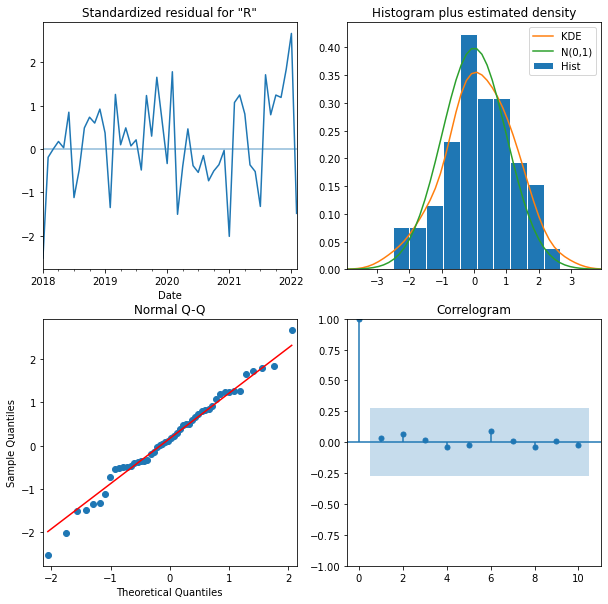

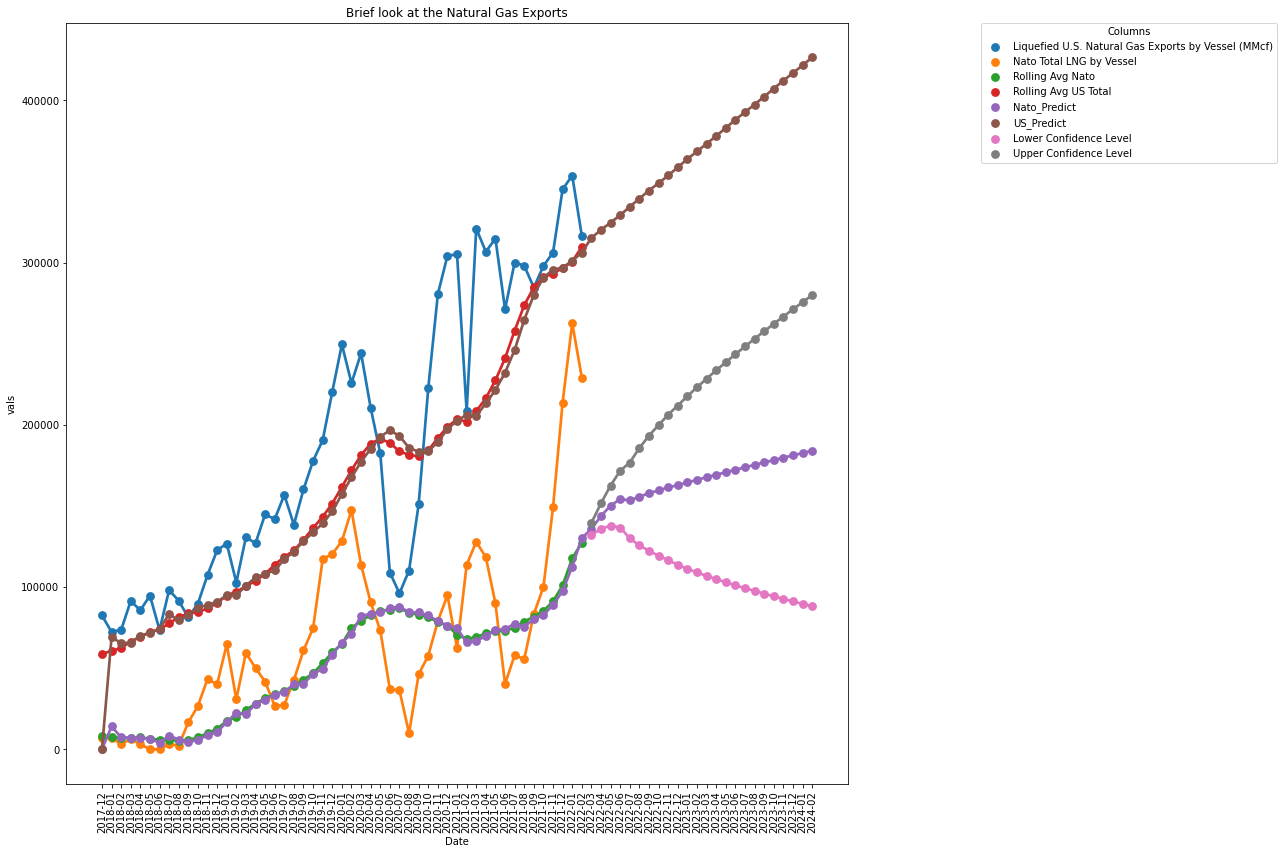

In [363]:
Model_4 = run_arimma(Arima_DF,6,1,6, True)

'Model Arima(6,2,6)'

c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dunca\anaco

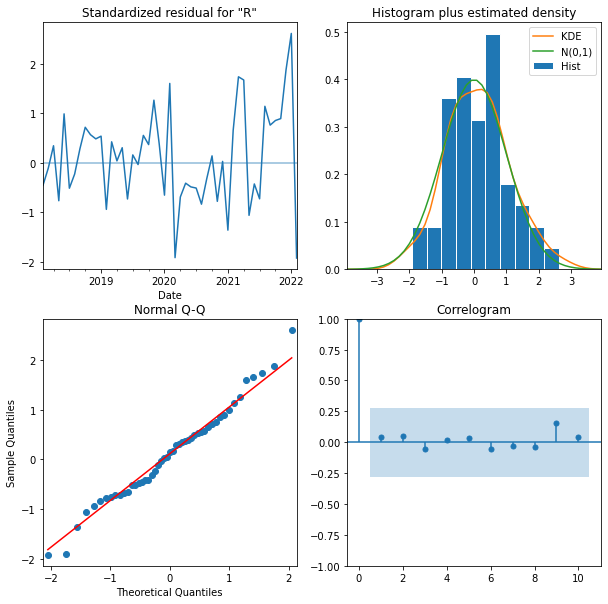

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Rolling Avg Nato   No. Observations:                   51
Model:                 ARIMA(6, 2, 6)   Log Likelihood                -440.991
Date:                Thu, 02 Jun 2022   AIC                            907.982
Time:                        20:00:19   BIC                            932.576
Sample:                    12-31-2017   HQIC                           917.313
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5624      0.564     -0.998      0.318      -1.667       0.542
ar.L2          0.2200      0.873      0.252      0.801      -1.492       1.932
ar.L3          0.2289      0.741      0.309      0.757      -1.223       1.681
ar.L4         -0.2113      0.596     -0.355      0.723      -1.379       0.957
ar.L5          0.3320      0.707      0.469      0.639      -1.054       1.718
ar.L6          0.4727      0.513      0.921      0.357      -0.533       1.478
ma.L1          0.3850      7.538      0.051      0.959     -14.388      15.158
ma.L2         -0.4401     19.039     -0.023      0.982     -37.756      36.876
ma.L3          0.0240     26.166      0.001      0.999     -51.260      51.308
ma.L4          0.4200     18.542      0.023      0.982     -35.921      36.761
ma.L5         -0.4066      7.433     -0.055      0.956     -14.975      14.162
ma.L6         -0.9754      0.585     -1.667      0.096      -2.122       0.172
sigma2      3.618e+06    1.3e-05   2.78e+11      0.000    3.62e+06    3.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.74   Prob(JB):                         0.81
Heteroskedasticity (H):               5.80   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.71e+28. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Rolling Avg US Total   No. Observations:                   51
Model:                   ARIMA(6, 2, 6)   Log Likelihood                -450.667
Date:                  Thu, 02 Jun 2022   AIC                            927.334
Time:                          20:00:19   BIC                            951.927
Sample:                      12-31-2017   HQIC                           936.664
                           - 02-28-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0580      1.947      0.030      0.976      -3.759       3.875
ar.L2         -0.2265      0.406     -0.558      0.577      -1.022       0.569
ar.L3         -0.3219      0.576     -0.558      0.577      -1.452       0.808
ar.L4          0.0014      0.552      0.003      0.998      -1.080       1.083
ar.L5         -0.8497      0.245     -3.464      0.001      -1.331      -0.369
ar.L6         -0.0889      1.851     -0.048      0.962      -3.716       3.538
ma.L1         -0.0864      1.962     -0.044      0.965      -3.932       3.759
ma.L2          0.1729      0.458      0.377      0.706      -0.725       1.071
ma.L3          0.3066      0.577      0.532      0.595      -0.823       1.437
ma.L4         -0.0332      0.661     -0.050      0.960      -1.329       1.262
ma.L5          0.8561      0.267      3.204      0.001       0.332       1.380
ma.L6          0.0272      1.979      0.014      0.989      -3.852       3.907
sigma2      6.434e+06    1.3e-06   4.95e+12      0.000    6.43e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.06   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.08   Prob(JB):                         0.54
Heteroskedasticity (H):               3.77   Skew:                             0.25
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+29. Standard errors may be unstable.
"""

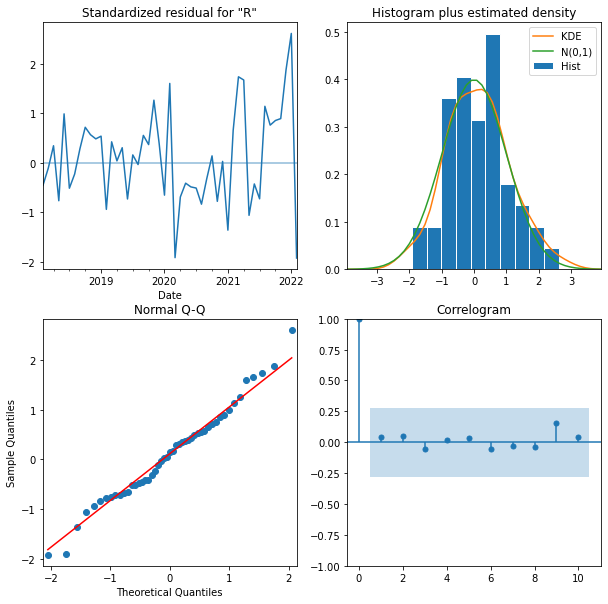

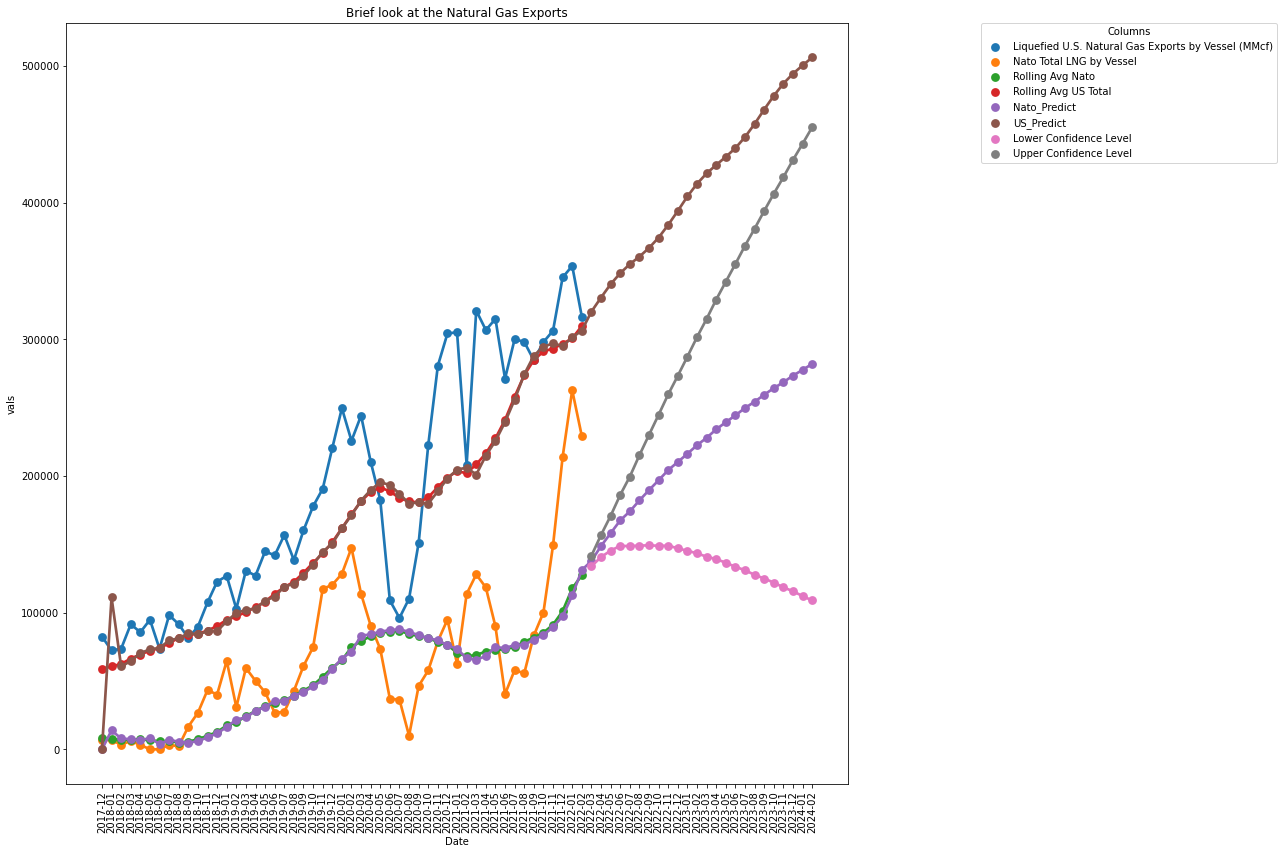

In [366]:
Model_4 = run_arimma(Arima_DF,6,2,6, True)